In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import logging
import jax


logging.getLogger().setLevel(logging.INFO)
logging.getLogger("absl").setLevel(logging.DEBUG)

set_matplotlib_formats("svg")


def plot_summary(ax, x, y, truth=None):
    q25, q50, q75 = np.quantile(y, [0.25, 0.5, 0.75], axis=0)
    assert len(set(x)) == 1
    x = x[0]
    ax.plot(x, q50, color="tab:blue")
    ax.fill_between(x, q25, q75, alpha=0.2, color="tab:blue")
    if truth is not None:
        x0 = np.arange(len(truth))
        ax.plot(x0, truth, "--", alpha=0.5, color="tab:grey")

<IPython.core.display.Javascript object>

In [2]:
from sim import sim_and_fit, sim_wf
from estimate import posterior_decoding, sample_paths
from common import Observation

<IPython.core.display.Javascript object>

## Various models

NameError: name 'fig' is not defined

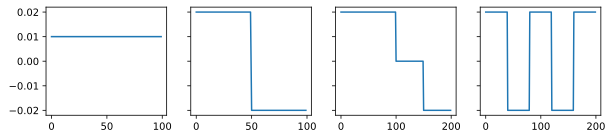

<IPython.core.display.Javascript object>

In [3]:
mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 100 + [0.0] * 50 + [-0.02] * 50, "h": [0.5] * 200, "f0": 0.1},
    {"s": (([0.02] * 40 + [-0.02] * 40) * 3)[:200], "h": [0.5] * 200, "f0": 0.5},
]
model = mdls[1]
# fig, axs = plt.subplots(ncols=len(mdls))
for m, ax in zip(mdls, plt.subplots(ncols=len(mdls), figsize=(10, 2), sharey=True)[1]):
    ax.plot(np.arange(len(m["s"])), m["s"])
fig.tight_layout()

## Posterior decoding

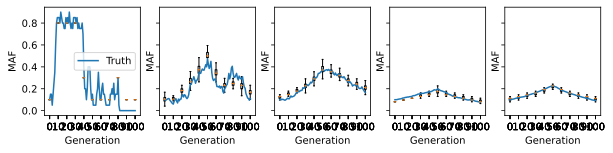

<IPython.core.display.Javascript object>

In [29]:
rng = np.random.default_rng()
mdl = mdls[1]
n = 100
k = 10
fig, axs = plt.subplots(ncols=5, figsize=(10, 2), sharex=True, sharey=True)
for log_Ne, ax in zip(range(1, 6), axs):
    Ne = 10 ** log_Ne
    af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
    obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

    data = [
        Observation(t=t, sample_size=n, num_derived=oo, Ne=Ne)
        for t, oo in zip(range(0, len(af), k), obs)
    ]

    pd = posterior_decoding(
        data,  # observed data
        mdl["s"][::k],
        mdl["h"][::k],  # parameters for HMM
        64,  # number of discretizations
    )
    pd.draw(ax)
    ax.plot(np.arange(len(af)), af, label="Truth")
    ax.set_xlabel("Generation")
axs[0].set_ylabel("MAF")    
axs[0].legend()

## With huge $N_e$

## Estimation
(Single example).

JIT compiling takes a long time, but subsequent calls are fast:

In [33]:
import logging

logging.getLogger("estimate").setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [34]:
%%time  
## First call to JIT (slow)
sim_and_fit(model, seed=1, lam_=1e2)

CPU times: user 1.73 s, sys: 324 ms, total: 2.06 s
Wall time: 1.41 s


{'t': (100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0),
 's': array([ 0.02606571,  0.05131949,  0.02958137, -0.00487671, -0.00156526,
        -0.04166452, -0.02644389, -0.03140592, -0.01884288, -0.01868352]),
 'obs': array([[100,   7],
        [100,  11],
        [100,  18],
        [100,  22],
        [100,  19],
        [100,  22],
        [100,  14],
        [100,  12],
        [100,   7],
        [100,   8],
        [100,   8]])}

<IPython.core.display.Javascript object>

In [35]:
%%time
## Second call, already jitted
sim_and_fit(model, seed=2, lam_=1e2)

CPU times: user 1.36 s, sys: 251 ms, total: 1.61 s
Wall time: 1.11 s


{'t': (100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0),
 's': array([ 0.01827201,  0.01606859,  0.00743098,  0.0141424 , -0.00016136,
        -0.00980459, -0.01790375, -0.06254897, -0.02339317, -0.02670024]),
 'obs': array([[100,  11],
        [100,  18],
        [100,  17],
        [100,  18],
        [100,  21],
        [100,  21],
        [100,  18],
        [100,  19],
        [100,   8],
        [100,   8],
        [100,   6]])}

<IPython.core.display.Javascript object>

In [36]:
%%time
model = mdls[1]
res = []
for seed in range(20):
    res.append(sim_and_fit(model, seed=seed, lam_=1e2))

CPU times: user 26.8 s, sys: 5.18 s, total: 31.9 s
Wall time: 21.2 s


<IPython.core.display.Javascript object>

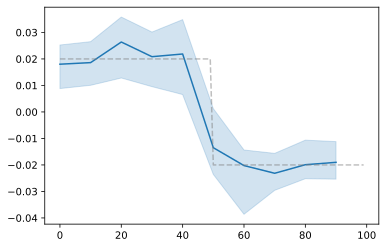

<IPython.core.display.Javascript object>

In [39]:
x, y = zip(*[(rr["t"][1:], -rr["s"]) for rr in res])

x, y = zip(*[(rr["t"][1:], -rr["s"]) for rr in res])
plot_summary(plt.gca(), x, y, model["s"])

## Path sampling (stochastic traceback)

CPU times: user 3.47 s, sys: 25.1 ms, total: 3.49 s
Wall time: 3.48 s


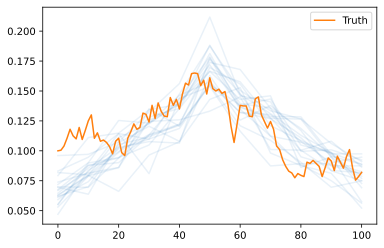

<IPython.core.display.Javascript object>

In [18]:
%%time
Ne = int(1e3)
rng = np.random.default_rng()
mdl = mdls[1]
af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
n = 100
k = 10
obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

times = list(range(0, len(af), k))
data = [
    Observation(t=t, sample_size=n, num_derived=oo, Ne=Ne) for t, oo in zip(times, obs)
]
paths = sample_paths(
    data,  # observed data
    mdl["s"][::k],
    mdl["h"][::k],  # parameters for HMM
    64,  # number of discretizations
    20,  # number of paths
)
plt.plot(
    times,
    paths.T + np.random.normal(size=paths.T.shape, scale=0.01), # FIXME: correctly sample within discretized states
    color="tab:blue",
    alpha=0.1,
)  
plt.plot(np.arange(len(af)), af, color="tab:orange", label="Truth")
plt.legend()